# Comparison of Uplift modeling packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklift.models import SoloModel, ClassTransformation, TwoModels
from pyuplift.transformation import Lai, Kane, Jaskowski, Pessimistic, Reflective

from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain, auuc_score

import warnings
warnings.simplefilter("ignore", UserWarning)
from datasets import HillstromDataset

data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=1)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)

## Estimation

In [2]:
### CausalML

# S Learner
learner_s = BaseSClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
uplift_forest = uplift_model.predict(X=X_test)

### pyuplift

model_lai = Lai(model=RandomForestClassifier(n_estimators=300))
model_lai.fit(X_train, y_train, w_train)
pred_lai = model_lai.predict(X_test)

model_kane = Kane(model=RandomForestClassifier(n_estimators=300))
model_kane.fit(X_train, y_train, w_train)
pred_kane = model_kane.predict(X_test)

model_jaskowski = Jaskowski(model=RandomForestClassifier(n_estimators=300))
model_jaskowski.fit(X_train, y_train, w_train)
pred_jask = model_jaskowski.predict(X_test)

model_pess = Pessimistic(model=RandomForestClassifier(n_estimators=300))
model_pess.fit(X_train, y_train, w_train)
pred_pess = model_pess.predict(X_test)

model_refl = Reflective(model=RandomForestClassifier(n_estimators=300))
model_refl.fit(X_train, y_train, w_train)
pred_refl = model_refl.predict(X_test)

### sklift


solo_model = SoloModel(RandomForestClassifier(n_estimators=300))
solo_model = solo_model.fit(X_train, y_train, w_train)
pred_1 = solo_model.predict(X_test)

solo_model_w_treatment = SoloModel(RandomForestClassifier(n_estimators=300), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

class_model = ClassTransformation(RandomForestClassifier(n_estimators=300))
class_model = class_model.fit(X_train, y_train, w_train)
pred_3 = class_model.predict(X_test)

two_models_vanilla = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300))
two_models_vanilla = two_models_vanilla.fit(X_train, y_train, w_train)
pred_4 = two_models_vanilla.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)

## Visualization

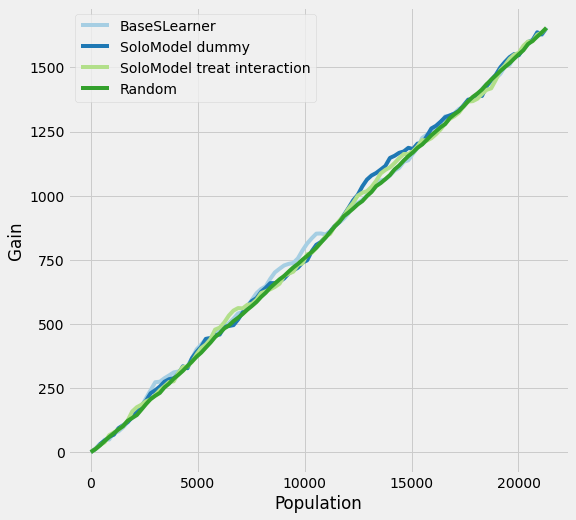

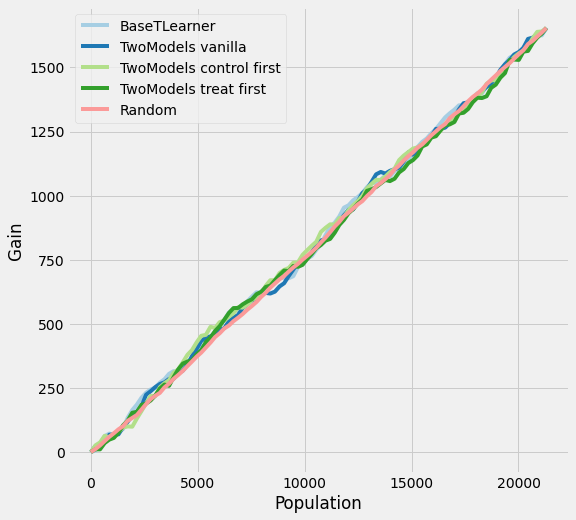

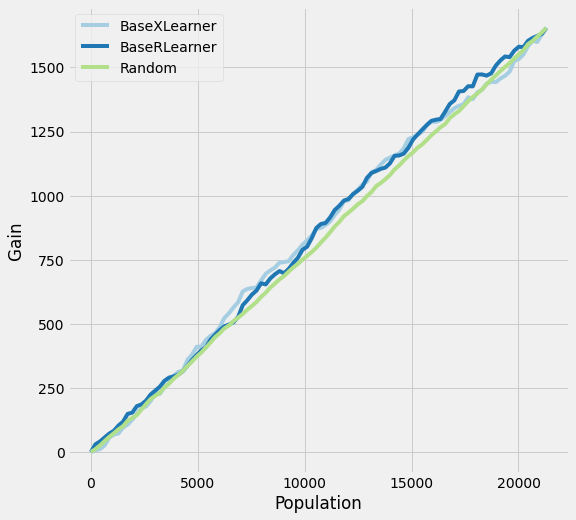

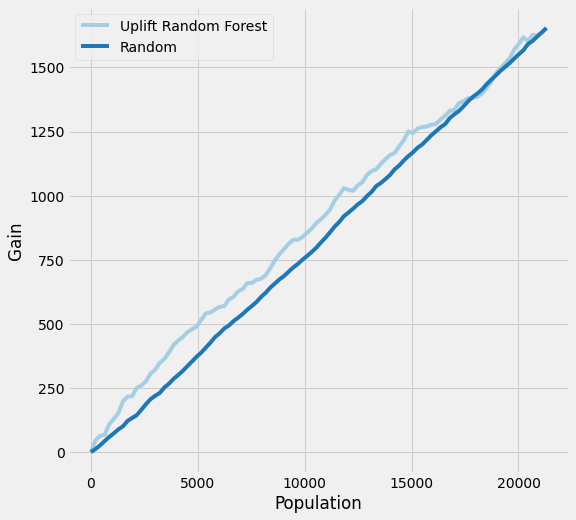

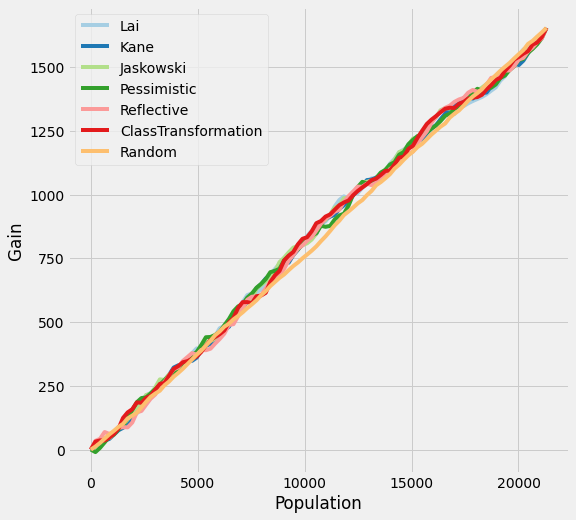

In [3]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseSLearner': cate_s_test.flatten(),
                   'SoloModel dummy': pred_1.flatten(), 'SoloModel treat interaction': pred_2.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

S_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseTLearner': cate_t_test.flatten(),
                   'TwoModels vanilla': pred_4.flatten(), 'TwoModels control first': pred_5.flatten(), 'TwoModels treat first': pred_6.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

T_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseXLearner': cate_x_test.flatten(), 'BaseRLearner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

XR_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Random Forest': uplift_forest.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

URF = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Lai': pred_lai.flatten(), 'Kane': pred_kane.flatten(), 'Jaskowski': pred_jask.flatten(), 'Pessimistic': pred_pess.flatten(), 'Reflective': pred_refl.flatten(), 'ClassTransformation': pred_3.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

ClassTransf = auuc_score(df, outcome_col='y', treatment_col='w')

In [4]:
print("Area under the uplift curves:")
print(S_Learner)
print(T_Learner)
print(XR_Learner)
print(URF)
print(ClassTransf)

Area under the uplift curves:
BaseSLearner                   0.502126
SoloModel dummy                0.502359
SoloModel treat interaction    0.499194
Random                         0.495158
dtype: float64
BaseTLearner               0.502542
TwoModels vanilla          0.498788
TwoModels control first    0.502546
TwoModels treat first      0.493661
Random                     0.495158
dtype: float64
BaseXLearner    0.512423
BaseRLearner    0.515426
Random          0.495158
dtype: float64
Uplift Random Forest    0.538195
Random                  0.495158
dtype: float64
Lai                    0.507537
Kane                   0.504700
Jaskowski              0.508969
Pessimistic            0.506798
Reflective             0.504277
ClassTransformation    0.508108
Random                 0.495158
dtype: float64


## Womens campaign

In [5]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=2)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)

## Estimation

In [6]:
### CausalML

# S Learner
learner_s = BaseSClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
uplift_forest = uplift_model.predict(X=X_test)

### pyuplift

model_lai = Lai(model=RandomForestClassifier(n_estimators=300))
model_lai.fit(X_train, y_train, w_train)
pred_lai = model_lai.predict(X_test)

model_kane = Kane(model=RandomForestClassifier(n_estimators=300))
model_kane.fit(X_train, y_train, w_train)
pred_kane = model_kane.predict(X_test)

model_jaskowski = Jaskowski(model=RandomForestClassifier(n_estimators=300))
model_jaskowski.fit(X_train, y_train, w_train)
pred_jask = model_jaskowski.predict(X_test)

model_pess = Pessimistic(model=RandomForestClassifier(n_estimators=300))
model_pess.fit(X_train, y_train, w_train)
pred_pess = model_pess.predict(X_test)

model_refl = Reflective(model=RandomForestClassifier(n_estimators=300))
model_refl.fit(X_train, y_train, w_train)
pred_refl = model_refl.predict(X_test)

### sklift


solo_model = SoloModel(RandomForestClassifier(n_estimators=300))
solo_model = solo_model.fit(X_train, y_train, w_train)
pred_1 = solo_model.predict(X_test)

solo_model_w_treatment = SoloModel(RandomForestClassifier(n_estimators=300), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

class_model = ClassTransformation(RandomForestClassifier(n_estimators=300))
class_model = class_model.fit(X_train, y_train, w_train)
pred_3 = class_model.predict(X_test)

two_models_vanilla = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300))
two_models_vanilla = two_models_vanilla.fit(X_train, y_train, w_train)
pred_4 = two_models_vanilla.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)

## Visualization

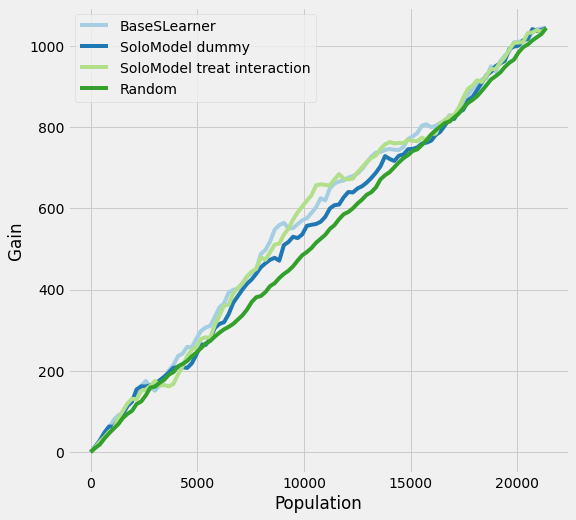

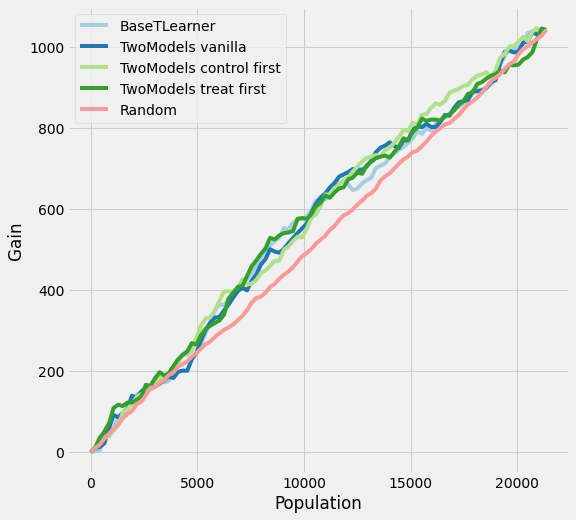

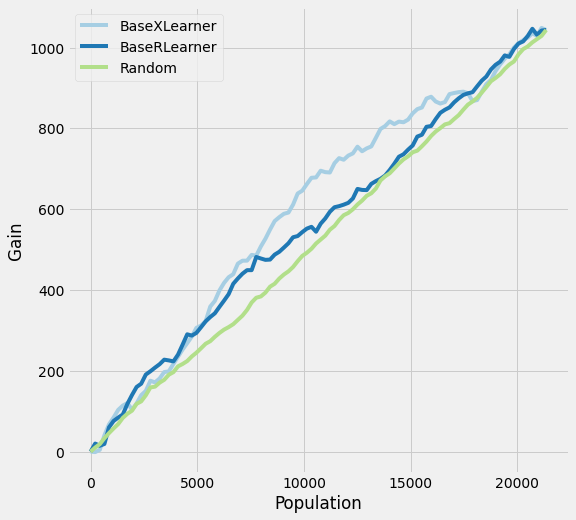

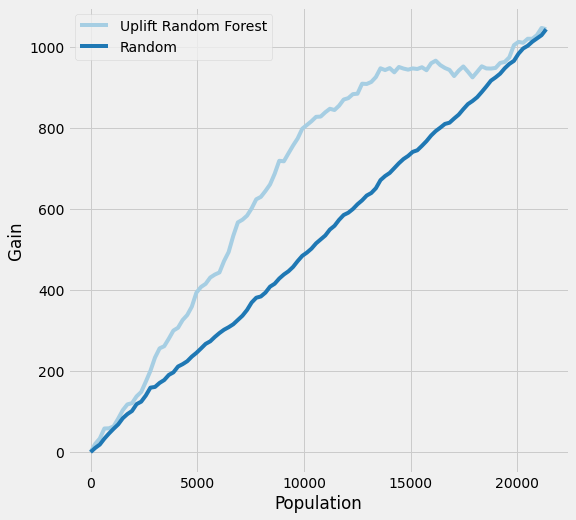

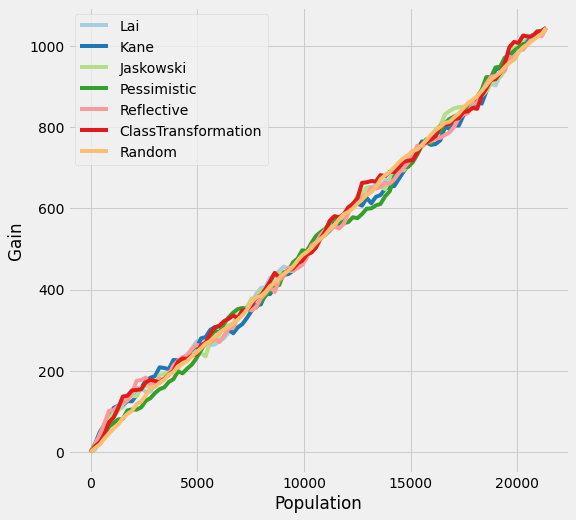

In [7]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseSLearner': cate_s_test.flatten(),
                   'SoloModel dummy': pred_1.flatten(), 'SoloModel treat interaction': pred_2.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

S_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseTLearner': cate_t_test.flatten(),
                   'TwoModels vanilla': pred_4.flatten(), 'TwoModels control first': pred_5.flatten(), 'TwoModels treat first': pred_6.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

T_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseXLearner': cate_x_test.flatten(), 'BaseRLearner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

XR_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Random Forest': uplift_forest.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

URF = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Lai': pred_lai.flatten(), 'Kane': pred_kane.flatten(), 'Jaskowski': pred_jask.flatten(), 'Pessimistic': pred_pess.flatten(), 'Reflective': pred_refl.flatten(), 'ClassTransformation': pred_3.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

ClassTransf = auuc_score(df, outcome_col='y', treatment_col='w')

In [8]:
print("Area under the uplift curves:")
print(S_Learner)
print(T_Learner)
print(XR_Learner)
print(URF)
print(ClassTransf)

Area under the uplift curves:
BaseSLearner                   0.544911
SoloModel dummy                0.523837
SoloModel treat interaction    0.542450
Random                         0.500102
dtype: float64
BaseTLearner               0.539733
TwoModels vanilla          0.539807
TwoModels control first    0.548491
TwoModels treat first      0.542997
Random                     0.500102
dtype: float64
BaseXLearner    0.573795
BaseRLearner    0.538357
Random          0.500102
dtype: float64
Uplift Random Forest    0.649047
Random                  0.500102
dtype: float64
Lai                    0.503242
Kane                   0.499756
Jaskowski              0.504136
Pessimistic            0.495690
Reflective             0.500208
ClassTransformation    0.506880
Random                 0.500102
dtype: float64
